# State Data Exploration

Setup file will need some digging into later

In [2]:
import sys
import os

#code_folder_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
#sys.path.append(code_folder_path)
#code_folder_path
from _Setup import *

In [3]:
state_data = pd.read_csv("C:/AA-Capstone/Data/Border_State_Data.csv", header = 0)


In [4]:
state_data.head(5)

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count
0,2022,FYTD,DEC,Northern Land Border,AK,Single Adults,CANADA,Title 8,3
1,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,CANADA,Title 8,6
2,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,1
3,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,OTHER,Title 8,2
4,2022,FYTD,DEC,Northern Land Border,ME,Accompanied Minors,CANADA,Title 42,1


As expected, our data runs from FY 2020 to the present day. 2025 (FYTD - Fiscal Year to Date). We'll just treat this as 2025 and change it in a bit

In [5]:
state_data['Fiscal Year'].unique() 

array(['2022', '2023', '2024', '2025 (FYTD)', '2020', '2021'],
      dtype=object)

Month Grouping has a bit of an unclear definition in their Data Dictionary. We explain this more in the report.

In [6]:
state_data['Month Grouping'].unique()

array(['FYTD', 'Remaining'], dtype=object)

In [7]:
remaining = state_data[state_data["Month Grouping"] == "Remaining"]

Remaining Month Tag does not apply to the months of Oct, Nov, and December.

In [8]:
remaining["Month (abbv)"].unique()

array(['APR', 'AUG', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'SEP'],
      dtype=object)

In [9]:
len(state_data['State'].unique())


48

No encounters in Iowa or West Virginia. The other 48 states, however, do.

In [10]:
state_data['State'].unique()

array(['AK', 'ID', 'ME', 'MI', 'MN', 'MT', 'ND', 'NY', 'OH', 'VT', 'WA',
       'AL', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI',
       'IL', 'LA', 'MA', 'MD', 'MP', 'MS', 'NC', 'NJ', 'NV', 'OR', 'PA',
       'PR', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'VI', 'NM', 'MO', 'NH',
       'WI', 'KY', 'IN', 'OK'], dtype=object)

In [11]:
authority_df = state_data[["Title of Authority", "Encounter Count"]]

True to online reports, around 3 million encounters categorized under Title 42

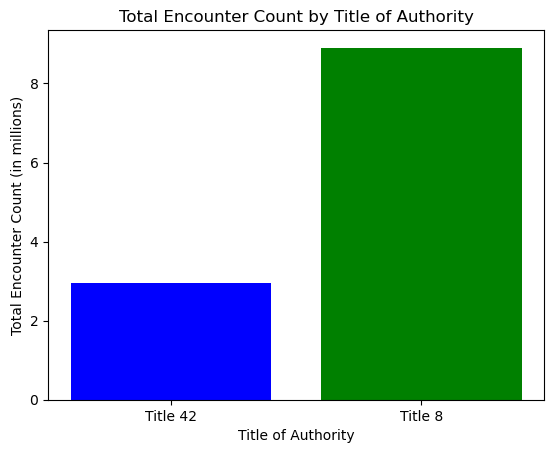

In [12]:
agg_authority = authority_df.groupby("Title of Authority", as_index =False).sum()

plt.bar(agg_authority['Title of Authority'], agg_authority['Encounter Count']/1000000, color=['blue', 'green'])
plt.xlabel('Title of Authority')
plt.ylabel('Total Encounter Count (in millions)')
plt.title('Total Encounter Count by Title of Authority')
plt.ticklabel_format(style='plain', axis='y')  # Remove scientific notation
plt.show()



In [13]:
agg_authority

,Title of Authority,Encounter Count
0,Title 42,2960908
1,Title 8,8904261


Let's try to account for fiscal year and month to create a new variable that will let us graph by time.

In [14]:
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

In [15]:

# although FYTD does not appear in any other year other than 2025 right now, this would be future proof if they use the same
# format in future years. Regex expression to remove FYTD and to just keep those years.
state_data['Fiscal Year'] = state_data['Fiscal Year'].str.replace(r'\s*\(FYTD\)', '', regex=True) 

# apply to each row a function where it takes in the fiscal year, subtracts 1 if the month falls into one of the months near the end 
# of the calendar year but is the start of a fiscal year. This gives us the accurate calendar year
state_data['Adjusted Fiscal Year'] = state_data.apply(
    lambda row: str(int(row['Fiscal Year']) - 1) if month_map[row['Month (abbv)']] in [10, 11, 12] else row['Fiscal Year'],
    axis=1
)

# Create 'MonthDate' column by combining fiscal year and month
state_data['MonthDate'] = pd.to_datetime(state_data['Adjusted Fiscal Year'] + '-' + state_data['Month (abbv)'].map(month_map).astype(str), format='%Y-%m')

Oct 2019 - Dec 2024 as confirmed by the data.

In [16]:
print(state_data["MonthDate"].min())
print(state_data["MonthDate"].max())

2019-10-01 00:00:00
2024-12-01 00:00:00


In [17]:
len(state_data["Citizenship"].unique())

22

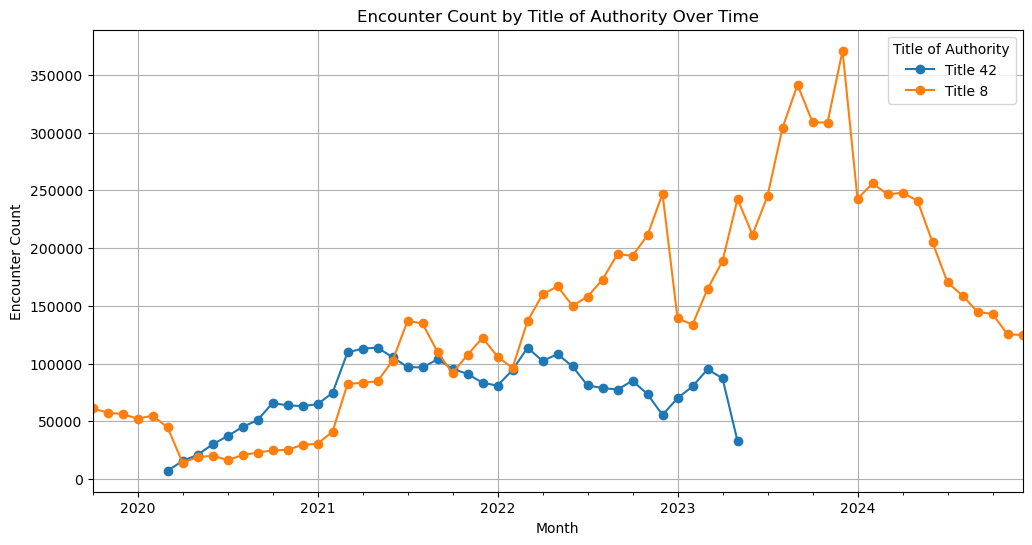

In [18]:
auth_df = state_data[["Title of Authority", "Encounter Count", "MonthDate"]]
df_agg = auth_df.groupby(['MonthDate', 'Title of Authority'])['Encounter Count'].sum().reset_index()
df_pivot = df_agg.pivot(index='MonthDate', columns='Title of Authority', values='Encounter Count')

# Plot the data
df_pivot.plot(figsize=(12,6), marker='o')
plt.xlabel('Month')
plt.ylabel('Encounter Count')
plt.title('Encounter Count by Title of Authority Over Time')
plt.legend(title='Title of Authority')
plt.grid(True)
plt.show()

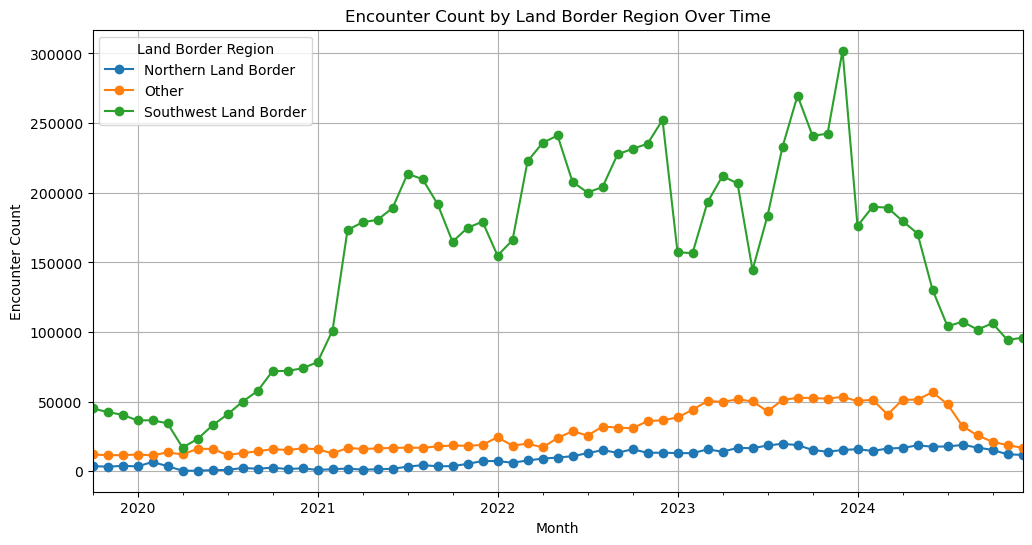

In [19]:
region_df = state_data[["Land Border Region", "Encounter Count", "MonthDate"]]
df_agg = region_df.groupby(['MonthDate', 'Land Border Region'])['Encounter Count'].sum().reset_index()
df_pivot = df_agg.pivot(index='MonthDate', columns='Land Border Region', values='Encounter Count')

# Plot the data
df_pivot.plot(figsize=(12,6), marker='o')
plt.xlabel('Month')
plt.ylabel('Encounter Count')
plt.title('Encounter Count by Land Border Region Over Time')
plt.legend(title='Land Border Region')
plt.grid(True)
plt.show()

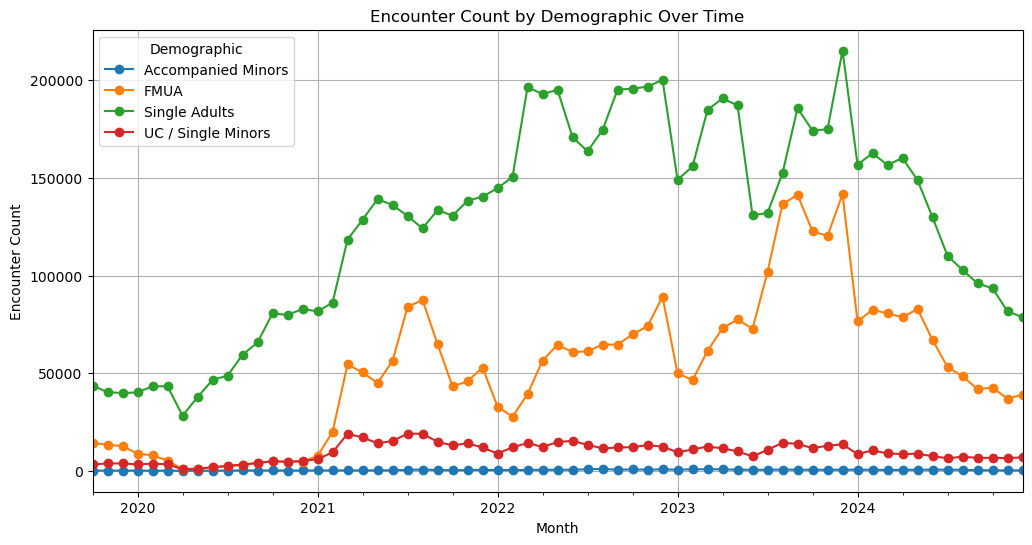

In [20]:
demo_df = state_data[["Demographic", "Encounter Count", "MonthDate"]]

df_agg = demo_df.groupby(['MonthDate', 'Demographic'])['Encounter Count'].sum().reset_index()
df_pivot = df_agg.pivot(index='MonthDate', columns='Demographic', values='Encounter Count')

# Plot the data
fig, ax = plt.subplots(figsize=(12,6))
df_pivot.plot(ax=ax, marker='o')  # Assign ax to the plot
plt.xlabel('Month')
plt.ylabel('Encounter Count')
plt.title('Encounter Count by Demographic Over Time')
plt.legend(title='Demographic')
plt.grid(True)
color_map = {label: line.get_color() for label, line in zip(df_pivot.columns, ax.get_lines())}
plt.show()

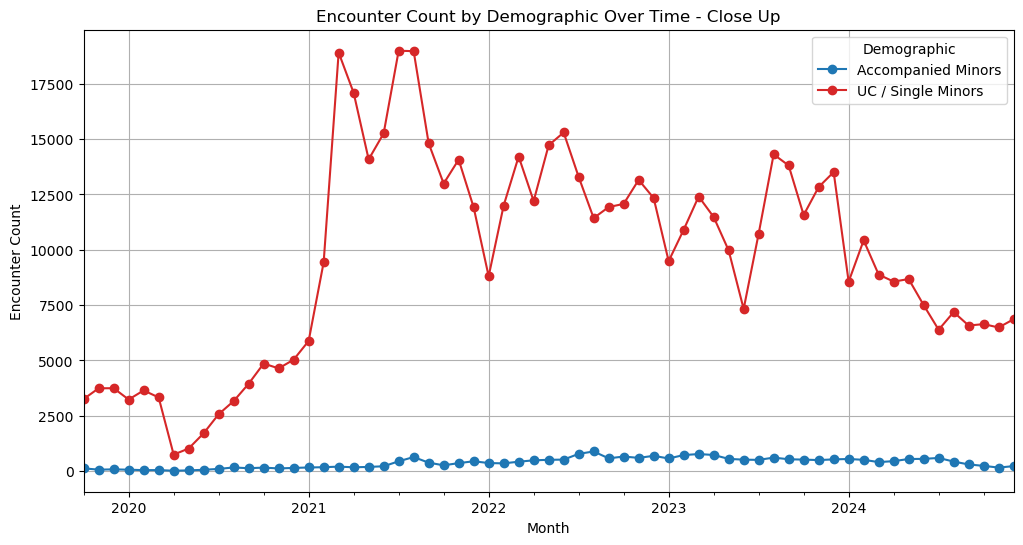

In [21]:
demo_df = demo_df[(demo_df["Demographic"] == "UC / Single Minors") | (demo_df["Demographic"] == "Accompanied Minors")]
df_agg = demo_df.groupby(['MonthDate', 'Demographic'])['Encounter Count'].sum().reset_index()
df_pivot = df_agg.pivot(index='MonthDate', columns='Demographic', values='Encounter Count')

# Plot with consistent colors
fig, ax = plt.subplots(figsize=(12,6))
df_pivot.plot(ax=ax, marker='o', color=[color_map.get(col, 'gray') for col in df_pivot.columns])

plt.xlabel('Month')
plt.ylabel('Encounter Count')
plt.title('Encounter Count by Demographic Over Time - Close Up')
plt.legend(title='Demographic')
plt.grid(True)
plt.show()

PLenty more EDA that can be done for each variable, but this is a good Week2

# Here I wanted to look closer year by year

In [22]:
twenty = state_data[state_data["Fiscal Year"] == "2020"]

In [23]:
twenty

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count,Adjusted Fiscal Year,MonthDate
40287,2020,FYTD,APR,Northern Land Border,ID,Single Adults,CANADA,Title 8,2,2020,2020-04-01
40288,2020,FYTD,APR,Northern Land Border,ME,Single Adults,CANADA,Title 42,2,2020,2020-04-01
40289,2020,FYTD,APR,Northern Land Border,ME,Single Adults,CANADA,Title 8,153,2020,2020-04-01
40290,2020,FYTD,APR,Northern Land Border,ME,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 42,1,2020,2020-04-01
40291,2020,FYTD,APR,Northern Land Border,ME,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,0,2020,2020-04-01
...,...,...,...,...,...,...,...,...,...,...,...
48226,2020,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,MEXICO,Title 42,1028,2020,2020-09-01
48227,2020,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,MEXICO,Title 8,32,2020,2020-09-01
48228,2020,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,NICARAGUA,Title 8,9,2020,2020-09-01
48229,2020,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,OTHER,Title 42,2,2020,2020-09-01


In [24]:
twenty["Month Grouping"].unique()


array(['FYTD'], dtype=object)

In [25]:
twenone = state_data[state_data["Fiscal Year"] == "2021"]
twenone

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count,Adjusted Fiscal Year,MonthDate
48231,2021,FYTD,APR,Northern Land Border,ID,Single Adults,CANADA,Title 8,1,2021,2021-04-01
48232,2021,FYTD,APR,Northern Land Border,ME,Accompanied Minors,OTHER,Title 42,1,2021,2021-04-01
48233,2021,FYTD,APR,Northern Land Border,ME,FMUA,GUATEMALA,Title 8,2,2021,2021-04-01
48234,2021,FYTD,APR,Northern Land Border,ME,Single Adults,CANADA,Title 42,6,2021,2021-04-01
48235,2021,FYTD,APR,Northern Land Border,ME,Single Adults,CANADA,Title 8,8,2021,2021-04-01
...,...,...,...,...,...,...,...,...,...,...,...
57775,2021,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,NICARAGUA,Title 8,161,2021,2021-09-01
57776,2021,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,OTHER,Title 8,29,2021,2021-09-01
57777,2021,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,PERU,Title 8,9,2021,2021-09-01
57778,2021,FYTD,SEP,Southwest Land Border,TX,UC / Single Minors,TURKEY,Title 8,4,2021,2021-09-01


In [26]:
twentwo = state_data[state_data["Fiscal Year"] == "2022"]
twentwo

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count,Adjusted Fiscal Year,MonthDate
0,2022,FYTD,DEC,Northern Land Border,AK,Single Adults,CANADA,Title 8,3,2021,2021-12-01
1,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,CANADA,Title 8,6,2021,2021-12-01
2,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,1,2021,2021-12-01
3,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,OTHER,Title 8,2,2021,2021-12-01
4,2022,FYTD,DEC,Northern Land Border,ME,Accompanied Minors,CANADA,Title 42,1,2021,2021-12-01
...,...,...,...,...,...,...,...,...,...,...,...
11605,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,NICARAGUA,Title 8,284,2022,2022-09-01
11606,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,OTHER,Title 8,15,2022,2022-09-01
11607,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,PERU,Title 8,12,2022,2022-09-01
11608,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,TURKEY,Title 8,13,2022,2022-09-01


In [27]:
twentwo_remaining = twentwo[twentwo["Month Grouping"] == "Remaining"]
twentwo_remaining

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count,Adjusted Fiscal Year,MonthDate
2644,2022,Remaining,APR,Northern Land Border,AK,Single Adults,CANADA,Title 8,6,2022,2022-04-01
2645,2022,Remaining,APR,Northern Land Border,AK,Single Adults,OTHER,Title 8,1,2022,2022-04-01
2646,2022,Remaining,APR,Northern Land Border,ID,FMUA,CANADA,Title 8,4,2022,2022-04-01
2647,2022,Remaining,APR,Northern Land Border,ID,Single Adults,CANADA,Title 8,8,2022,2022-04-01
2648,2022,Remaining,APR,Northern Land Border,ID,Single Adults,INDIA,Title 8,1,2022,2022-04-01
...,...,...,...,...,...,...,...,...,...,...,...
11605,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,NICARAGUA,Title 8,284,2022,2022-09-01
11606,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,OTHER,Title 8,15,2022,2022-09-01
11607,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,PERU,Title 8,12,2022,2022-09-01
11608,2022,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,TURKEY,Title 8,13,2022,2022-09-01


In [28]:
twentwo_fytd = twentwo[twentwo["Month Grouping"] == "FYTD"]
twentwo_fytd[(twentwo_fytd["Citizenship"]=="NICARAGUA") & (twentwo_fytd["Encounter Count"] == 284)]

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count,Adjusted Fiscal Year,MonthDate


In [29]:
twenthree = state_data[state_data["Fiscal Year"] == "2023"]
twenthree

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count,Adjusted Fiscal Year,MonthDate
11610,2023,FYTD,DEC,Northern Land Border,AK,Single Adults,CANADA,Title 8,1,2022,2022-12-01
11611,2023,FYTD,DEC,Northern Land Border,AK,Single Adults,OTHER,Title 8,5,2022,2022-12-01
11612,2023,FYTD,DEC,Northern Land Border,AK,Single Adults,UKRAINE,Title 8,2,2022,2022-12-01
11613,2023,FYTD,DEC,Northern Land Border,ID,Single Adults,CANADA,Title 8,5,2022,2022-12-01
11614,2023,FYTD,DEC,Northern Land Border,ID,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,1,2022,2022-12-01
...,...,...,...,...,...,...,...,...,...,...,...
25034,2023,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,MEXICO,Title 8,874,2023,2023-09-01
25035,2023,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,NICARAGUA,Title 8,52,2023,2023-09-01
25036,2023,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,OTHER,Title 8,12,2023,2023-09-01
25037,2023,Remaining,SEP,Southwest Land Border,TX,UC / Single Minors,PERU,Title 8,14,2023,2023-09-01


In [30]:
twenfour = state_data[state_data["Fiscal Year"] == "2024"]

In [31]:
twenfive = state_data[state_data["Fiscal Year"] == "2025"]